In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [5]:
y_classes = get_yclasses(params, ker_integrals)

## Building a RF model for $\alpha _x$

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [18]:
rscl_df = pd.DataFrame(rscl_data, columns=[f"Feat_{i}" for i in range(300)])
rscl_df.head()

,Feat_0,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,Feat_10,Feat_11,Feat_12,Feat_13,Feat_14,Feat_15,Feat_16,Feat_17,Feat_18,Feat_19,Feat_20,Feat_21,Feat_22,Feat_23,Feat_24,Feat_25,Feat_26,Feat_27,Feat_28,Feat_29,Feat_30,Feat_31,Feat_32,Feat_33,Feat_34,Feat_35,Feat_36,Feat_37,Feat_38,Feat_39,...,Feat_260,Feat_261,Feat_262,Feat_263,Feat_264,Feat_265,Feat_266,Feat_267,Feat_268,Feat_269,Feat_270,Feat_271,Feat_272,Feat_273,Feat_274,Feat_275,Feat_276,Feat_277,Feat_278,Feat_279,Feat_280,Feat_281,Feat_282,Feat_283,Feat_284,Feat_285,Feat_286,Feat_287,Feat_288,Feat_289,Feat_290,Feat_291,Feat_292,Feat_293,Feat_294,Feat_295,Feat_296,Feat_297,Feat_298,Feat_299
0,0.007752,0.007970,0.007859,0.007362,0.006486,0.005304,0.003966,0.002714,0.001994,0.002240,0.003050,0.003977,0.004912,0.005853,0.006821,0.007831,0.008886,0.009962,0.010987,0.011842,0.012395,0.012538,0.012233,0.011535,0.010597,0.009640,0.008909,0.008615,0.008896,0.009777,0.011158,0.012818,0.014456,0.015753,0.016443,0.016368,0.015518,0.014031,0.012173,0.010274,...,0.007232,0.008779,0.010651,0.012499,0.013974,0.014804,0.014843,0.014102,0.012740,0.011034,0.009314,0.007892,0.007006,0.006765,0.007147,0.008007,0.009117,0.010217,0.011072,0.011524,0.011516,0.011093,0.010370,0.009490,0.008576,0.007702,0.006896,0.006155,0.005456,0.004751,0.003979,0.003113,0.002297,0.002097,0.002921,0.004195,0.005431,0.006386,0.006943,0.007078
1,0.007954,0.008204,0.008141,0.007703,0.006886,0.005750,0.004428,0.003127,0.002203,0.002156,0.002860,0.003798,0.004777,0.005768,0.006779,0.007827,0.008917,0.010024,0.011077,0.011962,0.012546,0.012728,0.012472,0.011835,0.010966,0.010080,0.009416,0.009176,0.009490,0.010383,0.011755,0.013390,0.014990,0.016243,0.016885,0.016765,0.015876,0.014360,0.012483,0.010577,...,0.007048,0.008521,0.010312,0.012065,0.013431,0.014139,0.014050,0.013184,0.011710,0.009914,0.008133,0.006691,0.005825,0.005651,0.006139,0.007133,0.008391,0.009640,0.010638,0.011223,0.011338,0.011026,0.010407,0.009622,0.008794,0.007998,0.007270,0.006617,0.006022,0.005428,0.004746,0.003904,0.002948,0.002241,0.002522,0.003646,0.004908,0.005939,0.006574,0.006770
2,0.008362,0.008377,0.008070,0.007380,0.006320,0.005004,0.003705,0.002974,0.003336,0.004407,0.005636,0.006833,0.007985,0.009136,0.010327,0.011577,0.012878,0.014184,0.015409,0.016428,0.017104,0.017328,0.017059,0.016351,0.015362,0.014322,0.013497,0.013124,0.013367,0.014270,0.015734,0.017530,0.019332,0.020792,0.021610,0.021597,0.020720,0.019109,0.017034,0.014844,...,0.006680,0.004955,0.003161,0.002609,0.003653,0.004712,0.005075,0.004610,0.003449,0.001902,0.000592,0.001249,0.001900,0.001845,0.001082,0.000412,0.001964,0.003593,0.004948,0.005842,0.006216,0.006138,0.005770,0.005298,0.004852,0.004459,0.004079,0.003681,0.003262,0.002817,0.002313,0.001764,0.001522,0.002185,0.003444,0.004810,0.005980,0.006746,0.006991,0.006697
3,0.071041,0.116141,0.157928,0.186144,0.193928,0.176297,0.131342,0.063197,0.047574,0.143523,0.244109,0.331524,0.394783,0.427744,0.430725,0.411673,0.385972,0.372340,0.382148,0.410700,0.443466,0.467947,0.478935,0.478557,0.474363,0.476278,0.492618,0.526711,0.576429,0.636274,0.699532,0.759315,0.808905,0.842098,0.853650,0.839802,0.798746,0.730959,0.639387,0.529448,...,0.235294,0.135007,0.063859,0.099112,0.173708,0.244687,0.307738,0.362627,0.409473,0.448187,0.478734,0.501774,0.519287,0.534609,0.551404,0.571638,0.593824,0.613037,0.622808,0.617796,0.595924,0.559370,0.514321,0.469429,0.433229,0.411235,0.404521,0.410693,0.425682,0.444243,0.459769,0.464925,0.453342,0.421539,0.370215,0.304493,0.233116,0.166677,0.114716,0.081142
4,0.008419,0.008817,0.008915,0.008637,0.007955,0.006909,0.005599,0.004194,0.002949,0.002305,0.002617,0.003497,0.004533,0.005599,0.006677,0.007779,0.008908,0.010039,0.011106,0.012004,0.012620,0.012869,0.012727,0.012255,0.011597,0.010952,0.010531,0.010513,0.011006,0.012017,0.013439,0.015058,0.016584,0.017720,0.018223,0.017961,0.016947,0.015341,0.013419,0.011513,...,0.006159,0.007627,0.009420,0.011146,0.012434,0.013009,0

In [9]:
model = RandomForestRegressor(n_estimators=40, max_features='sqrt', min_samples_split=5, n_jobs=-1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(rscl_df, y_classes['αx'], test_size=0.2, 
                                                    random_state=2, stratify = params['stencil_type'])

In [20]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [21]:
model.score(X_test ,y_test)

0.9588650291385905

In [26]:
fi = pd.DataFrame(np.array([rscl_df.columns,model.feature_importances_]).T, 
                  columns=['timestamp','fi'])

fi.sort_values('fi', ascending=False, inplace=True)

In [28]:
fi.head(10)

,timestamp,fi
88,Feat_88,0.0362251
118,Feat_118,0.0251529
126,Feat_126,0.0205073
128,Feat_128,0.0193992
117,Feat_117,0.0187524
127,Feat_127,0.0187133
68,Feat_68,0.01819
124,Feat_124,0.0170325
130,Feat_130,0.0169121
119,Feat_119,0.0167711


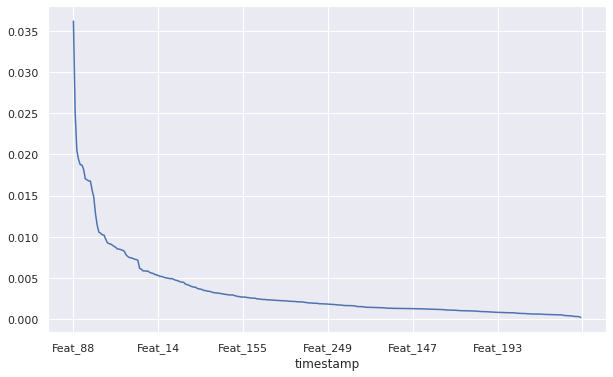

In [27]:
fi.plot('timestamp', 'fi', figsize=(10,6), legend=False);

In [59]:
def plot_fi(fi): return fi.plot('timestamp', 'fi', 'barh', legend=False)

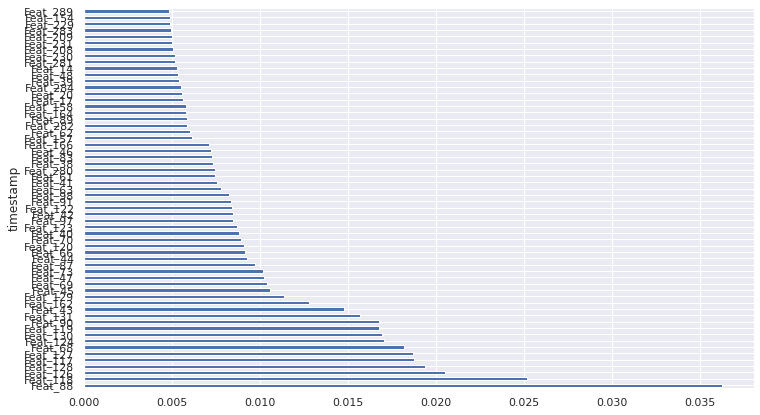

In [39]:
plot_fi(fi[:60]);

In [47]:
to_keep = fi[fi.fi>0.005].timestamp; len(to_keep)

55

In [50]:
df_keep = rscl_df[to_keep].copy()

X_train, X_test, y_train, y_test = train_test_split(df_keep, y_classes['αx'], test_size=0.2, 
                                                    random_state=2, stratify = params['stencil_type'])

In [81]:
model2 = RandomForestRegressor(n_estimators=40, max_features="sqrt",
                          n_jobs=-1, oob_score=True)
model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [82]:
model2.score(X_test, y_test)

0.9403908569125872

In [67]:
fi2 = pd.DataFrame(np.array([df_keep.columns, model2.feature_importances_]).T, 
                  columns=['timestamp','fi'])

fi2.sort_values('fi', ascending=False, inplace=True)

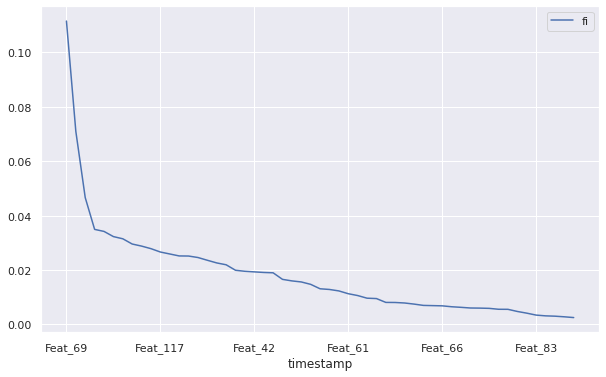

In [68]:
fi2.plot('timestamp', 'fi', figsize=(10,6))

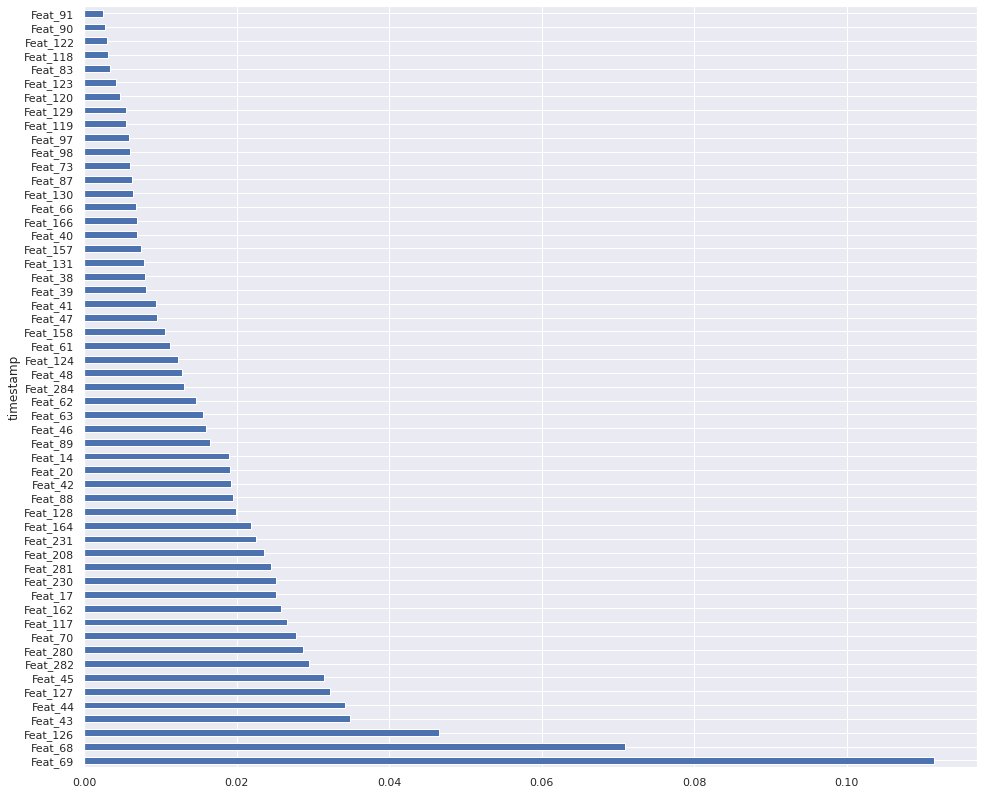

In [69]:
fig,ax = plt.subplots(figsize=(16,14))
fi2.plot('timestamp', 'fi', 'barh', legend=False, ax=ax)

# Removing redundant features

In [72]:
import scipy 
from scipy.cluster import hierarchy as hc

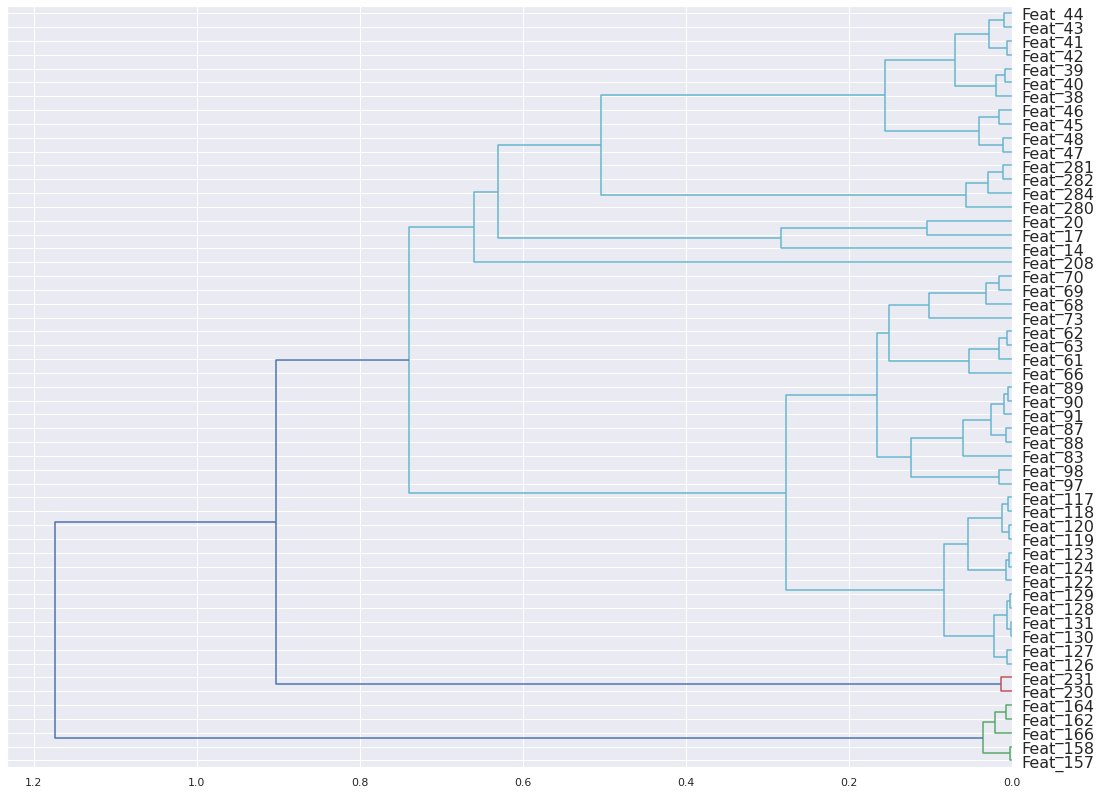

In [75]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')


fig = plt.figure(figsize=(18,14))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [77]:
!pip install pdpbox

     |████████████████████████████████| 34.0MB 94kB/s 
     |████████████████████████████████| 13.1MB 238kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=a78ff86505cf6312b219f2a8ab84e13f965274ef73c438341deb9cbe198318bb
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [78]:
from pdpbox import pdp
from plotnine import *